I used this jnb to plot the heatmaps of enrichments in SLAM counts. The color values are the fraction of genes of a signature that are used for the dynamical SLAM model (i.e. which bear dynamical information in some sense).

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
from tqdm import tnrange, tqdm_notebook
import matplotlib.backends.backend_pdf
from IPython.display import clear_output

import scvelo as scv
scv.settings.set_figure_params('scvelo', dpi_save=200, dpi=80, transparent=True)
scv.settings.verbosity = 3

/fast/users/peidlis_c/work/miniconda/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
data_path = '/fast/scratch/users/peidlis_c/sodar_patient_organoid_data/'
signatures_path = '/fast/work/users/peidlis_c/projects/sodar_patient_organoid_data/signatures/'

# heatmaps

In [4]:
def plot_heatmap(signature, name):
    
    a = np.zeros((len(signature.keys()), 2,3))
    b = np.empty((2,3), dtype=object)
    for i, letter in enumerate(['W', 'E']):
        for k, donor in enumerate(['p009ot', 'p013ot', 'NCO']):
            bdata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')

            SLAM_dyn_genes=bdata.var_names[bdata.var.dyn_velo_genes]
            
            # We simply count how many genes are actually used in SLAM dynamical model for each signature
            for j, ct in enumerate(signature.keys()):
                s=set(signature[ct])
                a[j,i,k]=len(SLAM_dyn_genes.intersection(s)) / len(SLAM_dyn_genes)
            b[i,k]=letter+ ' ' + donor

    pl.figure(dpi=200)
    im=pl.imshow(a.reshape((-1, 6)), vmin=0)
    hms = signature.keys()
    pl.yticks(np.arange(len(hms)), hms, fontsize=4);
    pl.xticks(np.arange(6), b.reshape(6), fontsize=4, rotation=90);
    pl.colorbar(im)
    pl.title(name + ' enrichment')
    pl.savefig('./figures/heatmap_'+name+'_SLAM.pdf')
    pl.show()

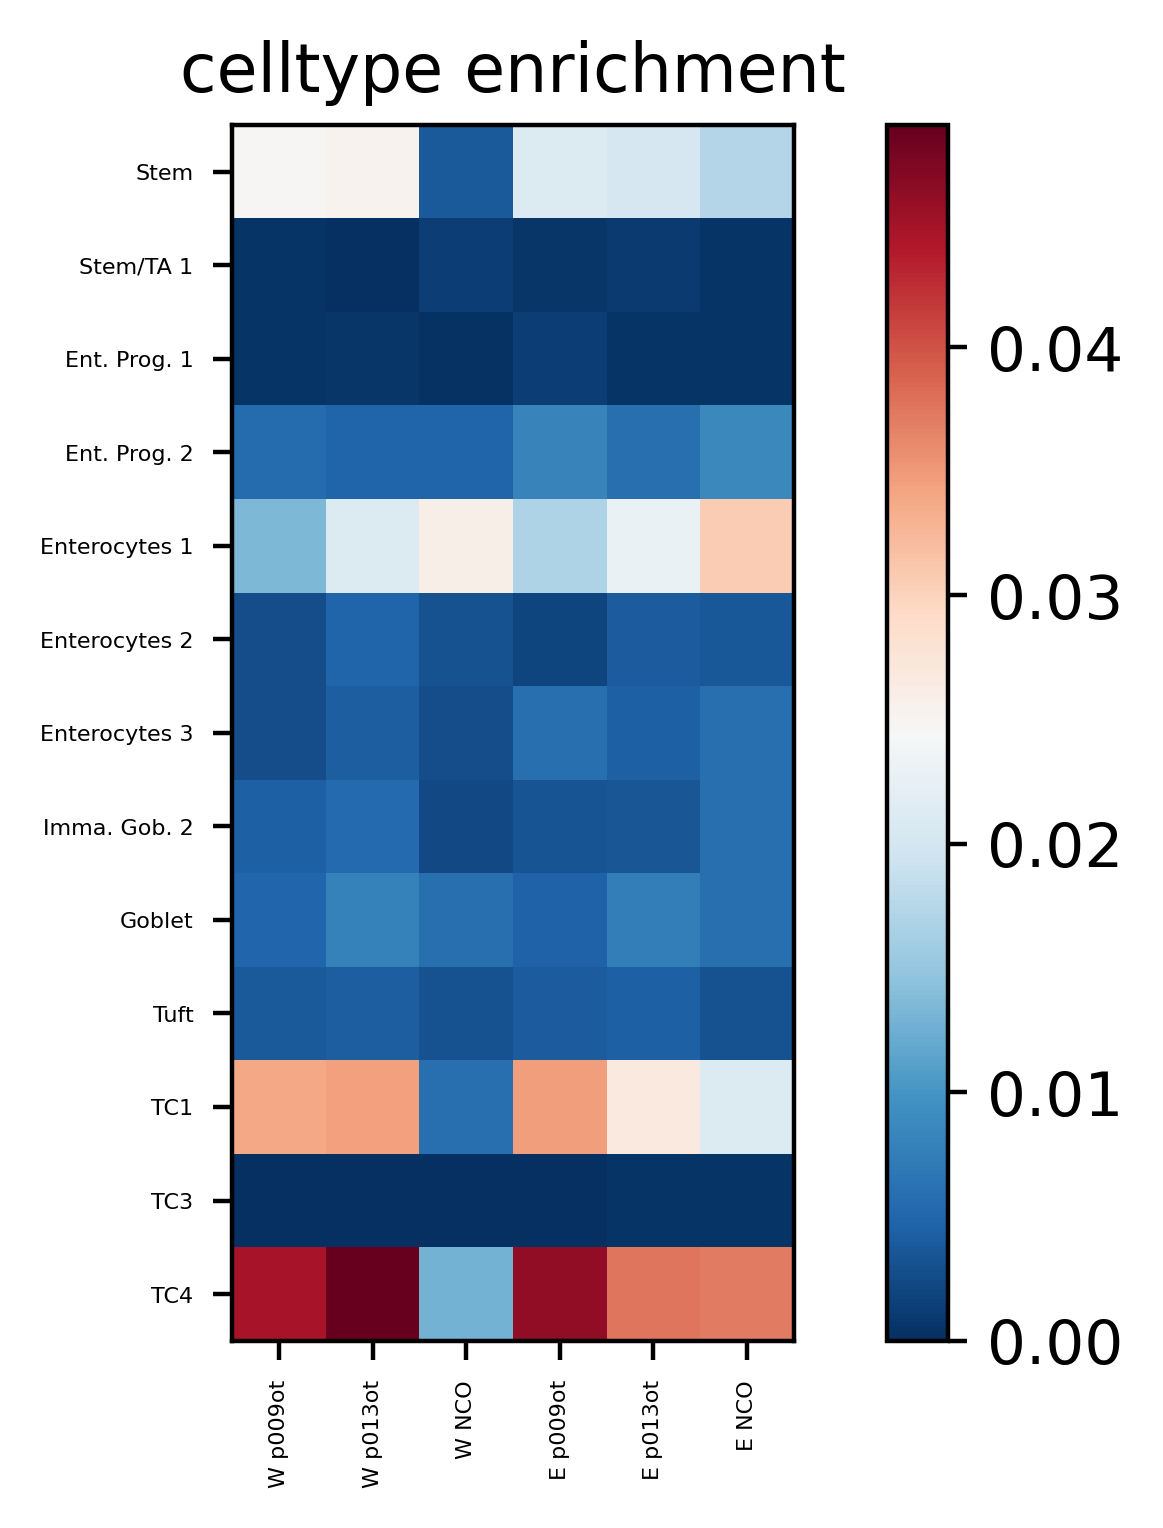

In [5]:
tab = pd.read_csv(signatures_path + 'cell_type_markers/cell_type_markers_epi.tsv', sep='\t')
tab = tab[tab.p_val_adj<0.01]
tab = tab[np.abs(tab.avg_logFC)> 0.75]
cell_types = pd.unique(tab.cell_type_epi)
cell_types = cell_types[cell_types!='Stem/TA 2']
cell_types = cell_types[cell_types!='Stem/TA 3']
cell_types = cell_types[cell_types!='Imma. Gob. 1']
cell_types = cell_types[cell_types!='TC2']
signature=dict([(ct, tab.gene.values[tab.cell_type_epi==ct]) for ct in cell_types])

plot_heatmap(signature, 'celltype')

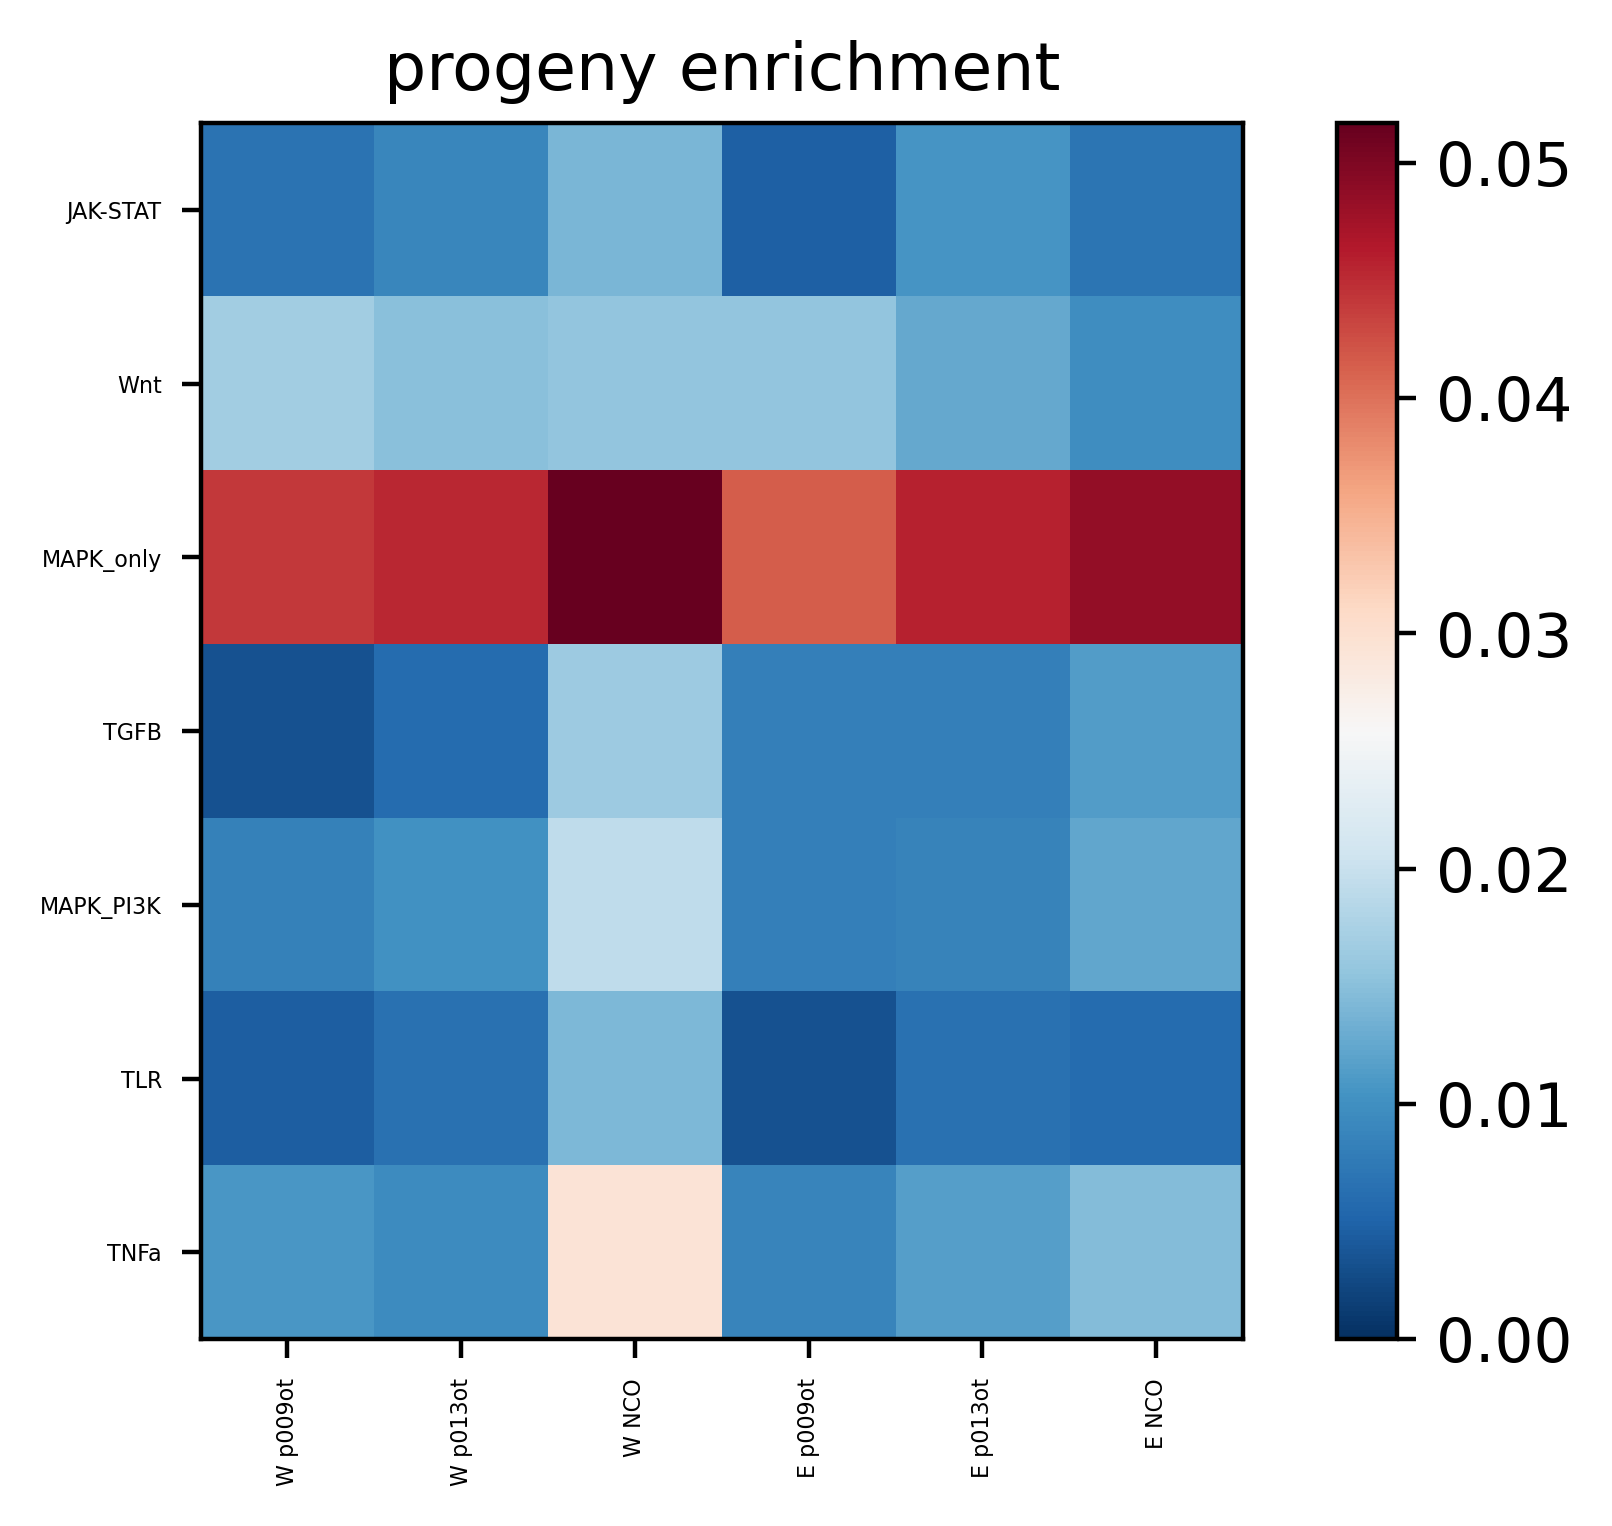

In [4]:
tab = pd.read_csv(signatures_path+'targets/progeny_pathways.csv', sep='\t', header=0)
signature = dict([(ids, tab[tab['#Pathway']==ids].Gene_Name.values) for ids in pd.unique(tab['#Pathway'])])
plot_heatmap(signature, 'progeny')

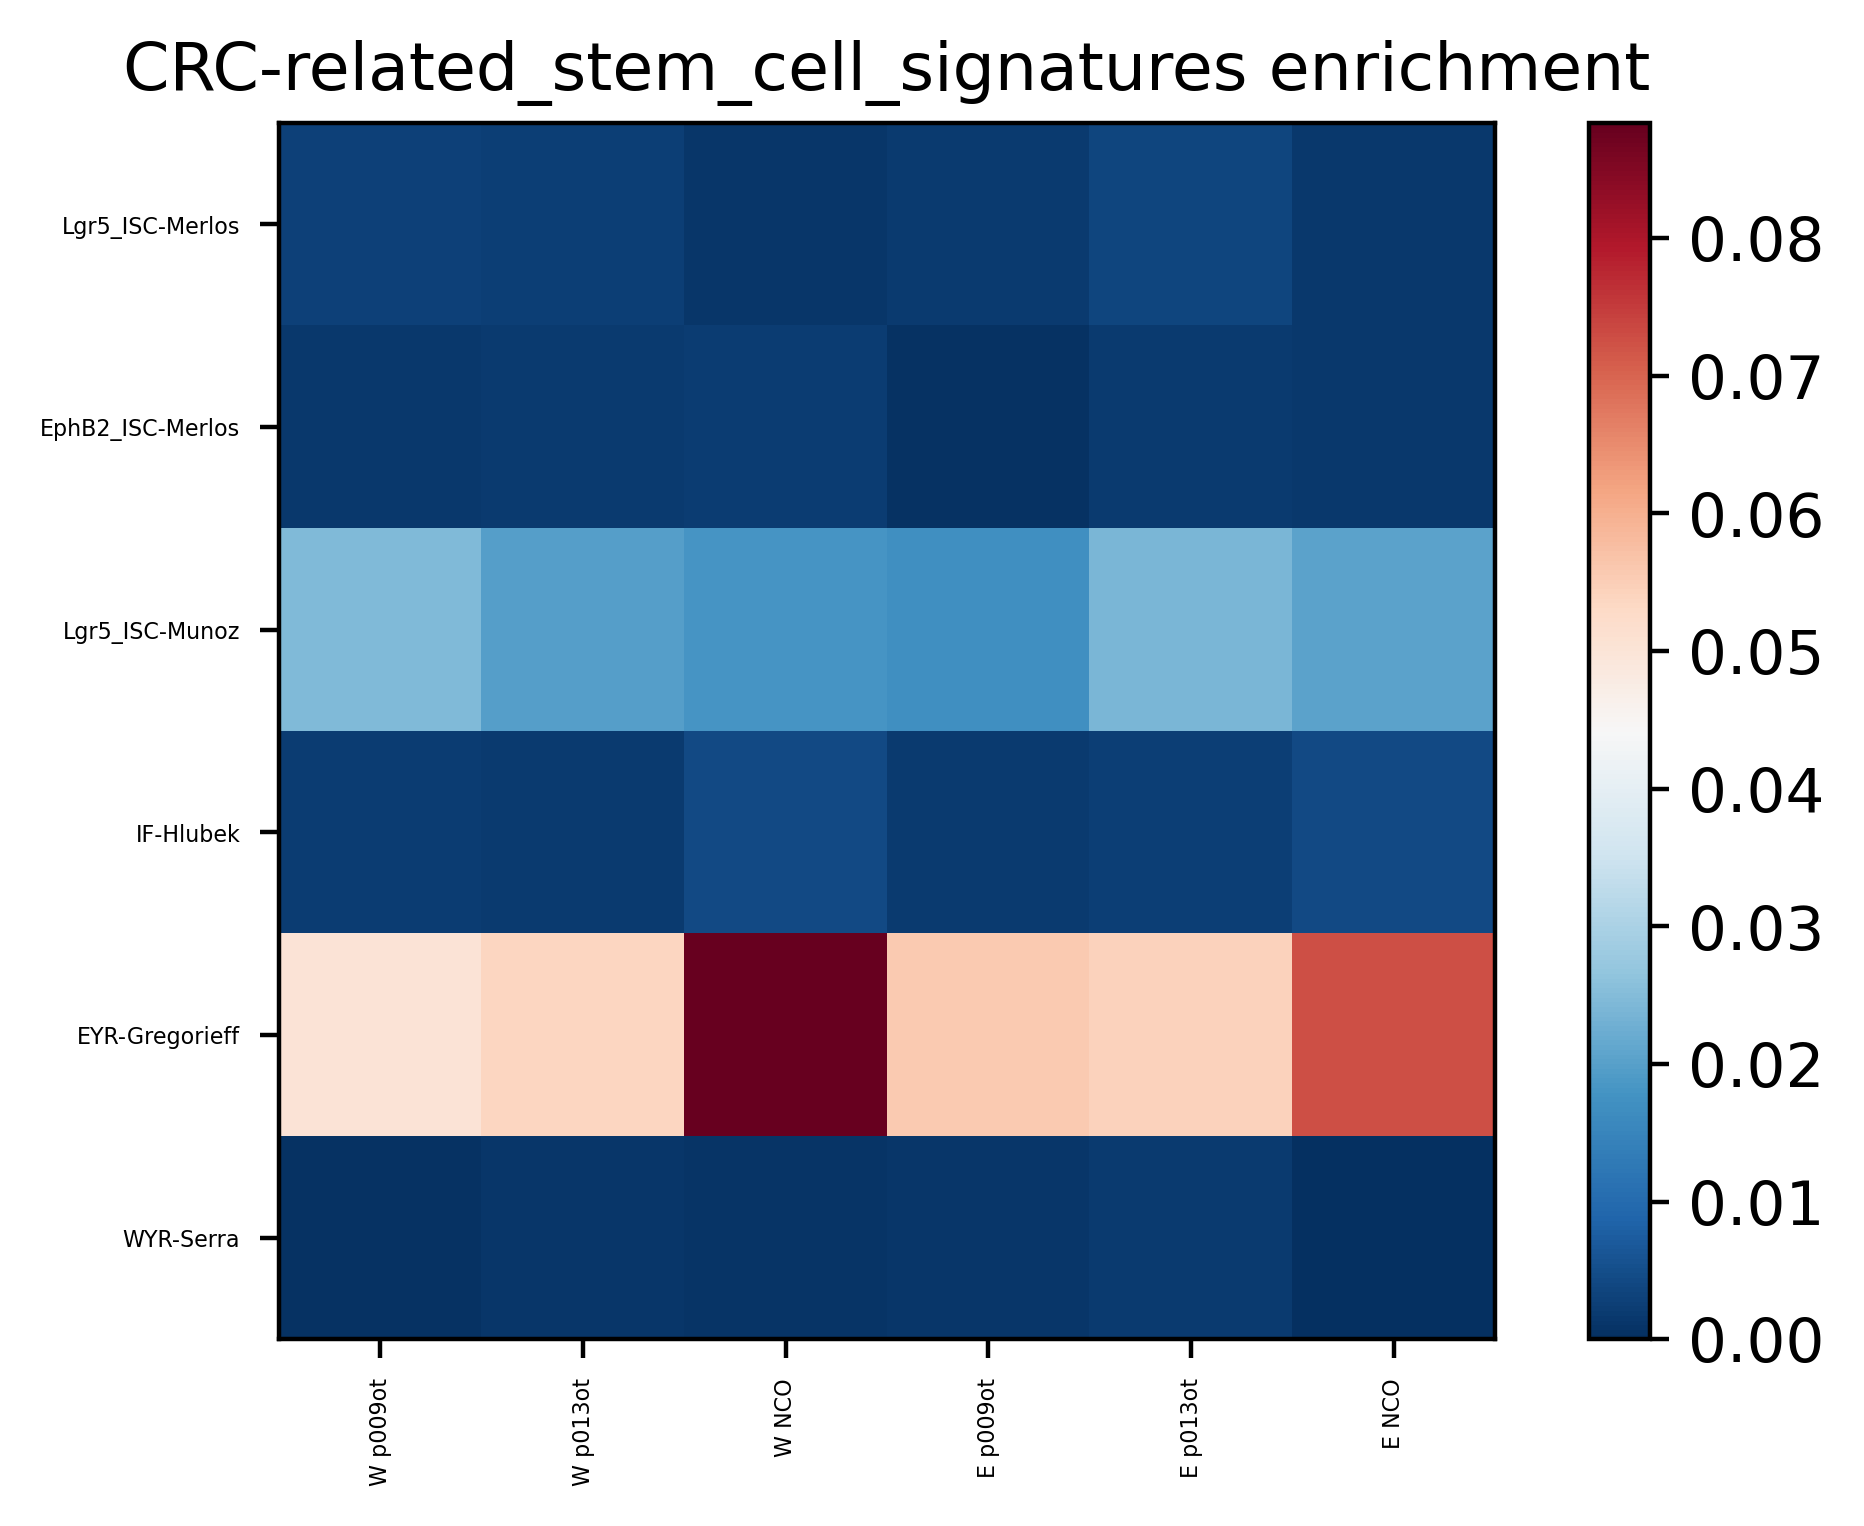

In [27]:
tab = pd.read_excel(signatures_path+'cell_type_markers/CRC-related_stem_cell_signatures.xlsx', index_col=None, header=0, skiprows=[1])
signature = dict([(ids, tab[ids][~pd.isna(tab[ids])].values) for ids in tab.columns])
plot_heatmap(signature, 'CRC-related_stem_cell_signatures')

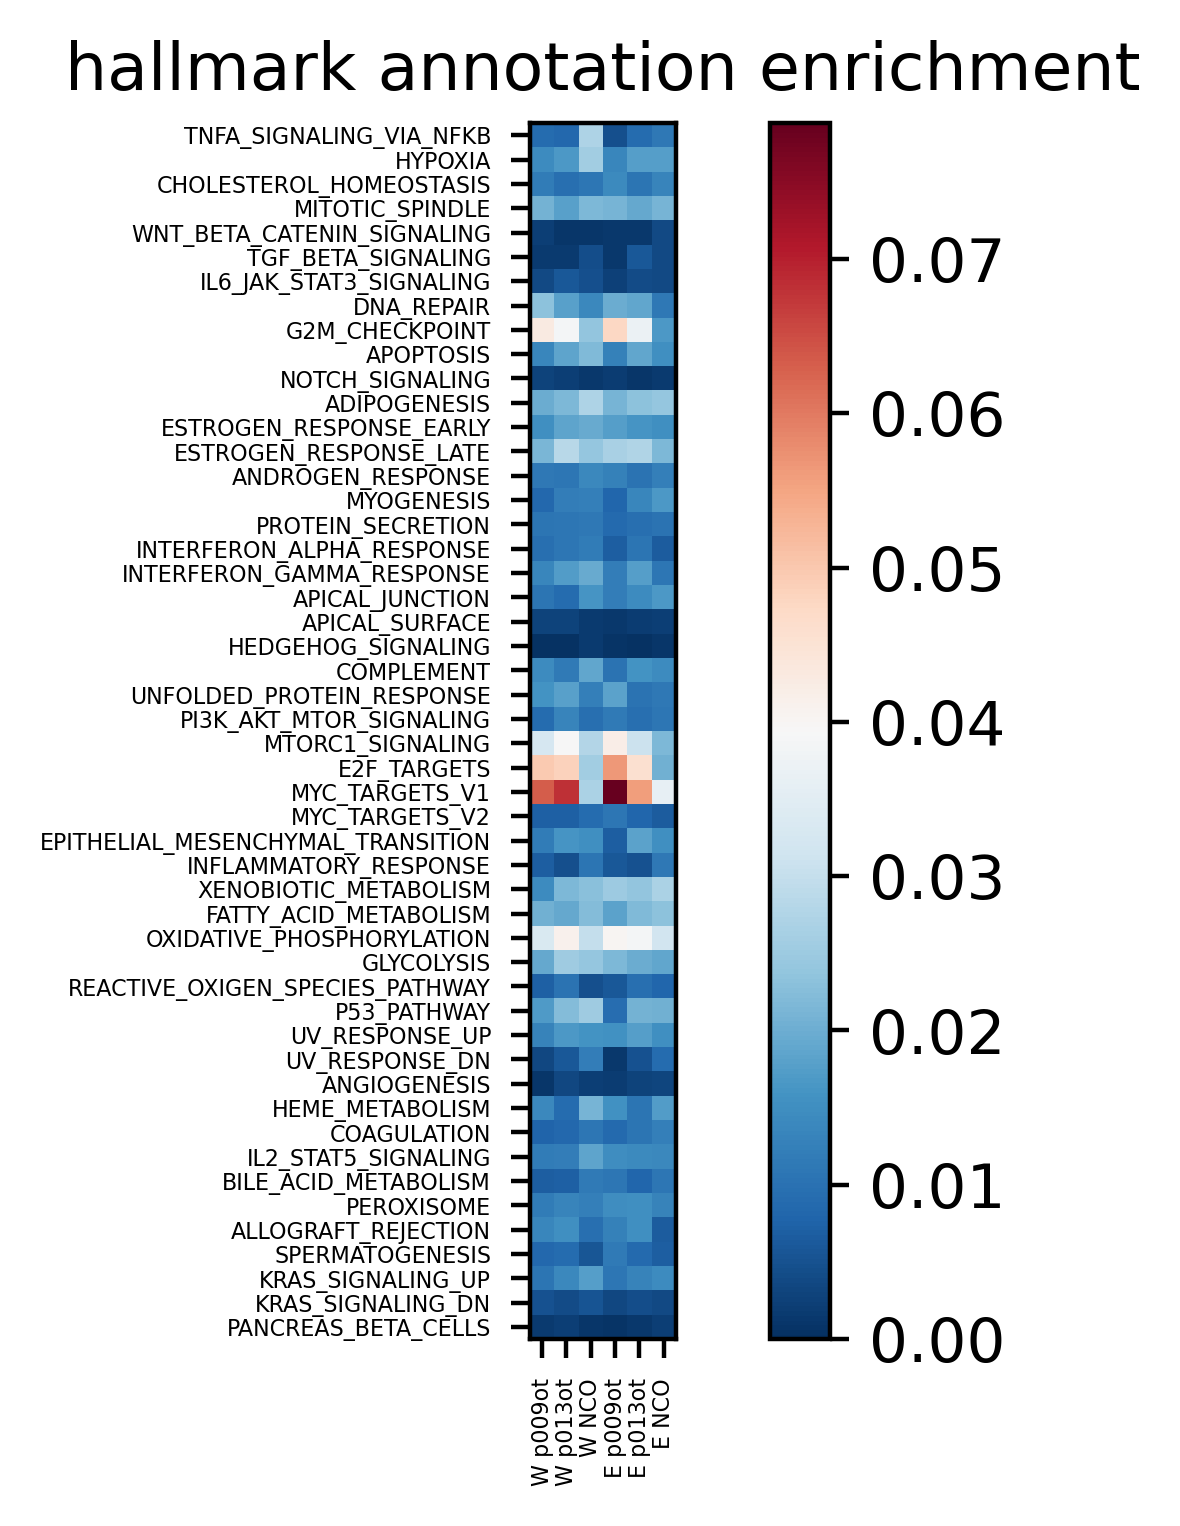

In [30]:
tab = pd.read_csv(signatures_path+'hallmarks/h.all.v6.2.symbols.gmt', sep='\t', index_col=None, header=None).T.drop(1)
tab.columns=tab.iloc[0]
tab = tab.drop(0)
signature = dict([(ids[9:], tab[ids][~pd.isna(tab[ids])].values) for ids in tab.columns])
plot_heatmap(signature, 'hallmark annotation')

In [9]:
tab = pd.read_excel("/fast/work/users/peidlis_c/utils/signatures/pathways/progeny_coefficients.xlsx", index_col=0,header=1)
signature_pos = dict([(ids+' +', tab[ids][tab[ids]>0].index) for ids in tab.columns])
signature_neg = dict([(ids+' -', tab[ids][tab[ids]<0].values) for ids in tab.columns])

signature = []
score = []
for ids in tab.columns:
    signature.append((ids+' +', tab[ids][tab[ids]>0]))
    signature.append((ids+' -', tab[ids][tab[ids]<0]))
signature = dict(signature)

In [ ]:
'MAPK'

In [8]:
ids+' +', tab[ids][tab[ids]>0]

('p53 +',
 ABCA12      9.597182
 ACER2      11.596064
 AK1         4.352992
 AKR1B10    10.322077
 ANKRA2     10.889631
              ...    
 ZMAT3       7.956698
 ZNF337      3.301763
 ZNF561     10.123218
 ZNF79       4.020263
 ZSCAN4      3.183463
 Name: p53, Length: 96, dtype: float64)

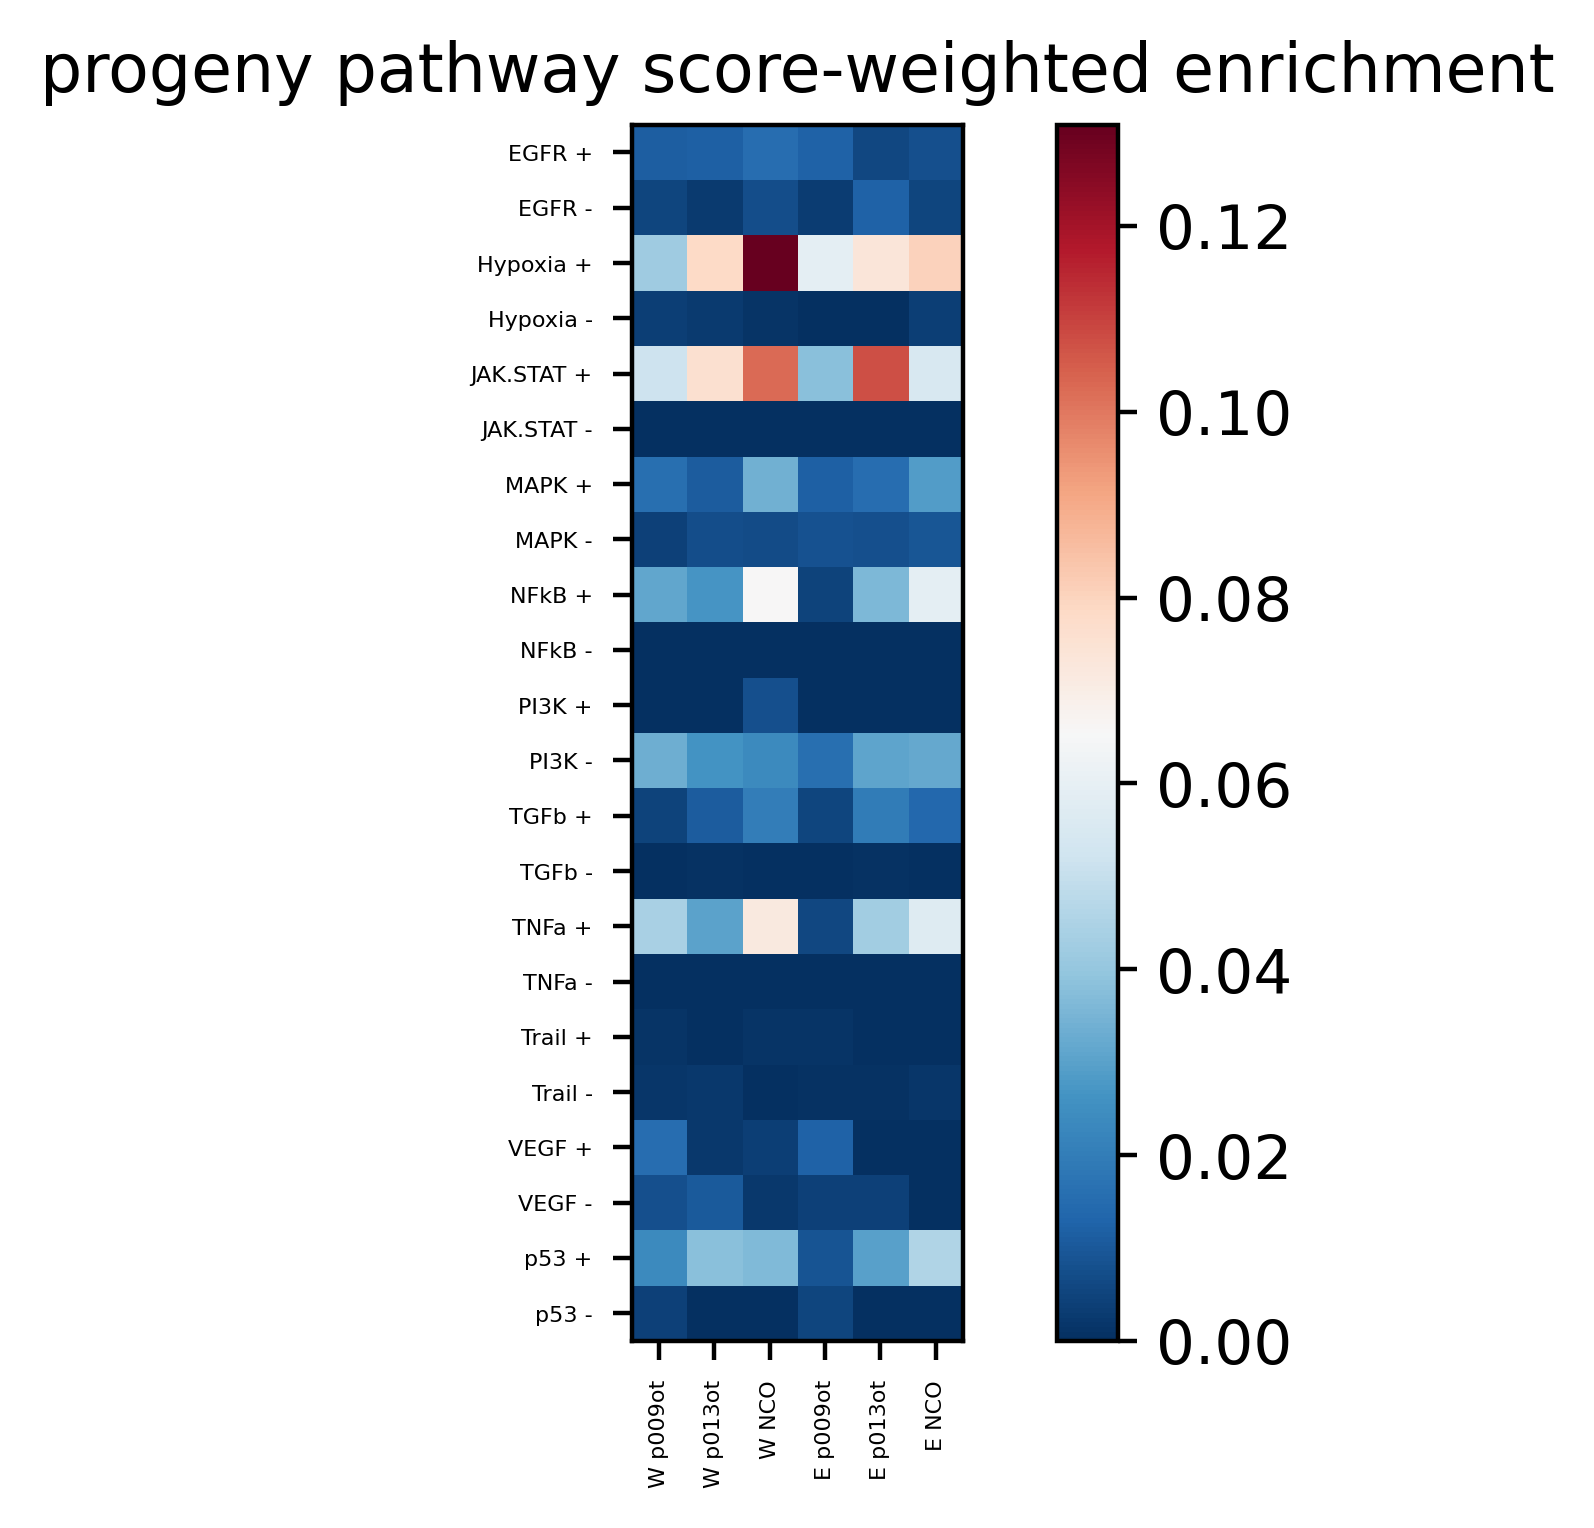

In [15]:
name = 'progeny pathway'

a = np.zeros((len(signature.keys()), 2,3))
b = np.empty((2,3), dtype=object)
for i, letter in enumerate(['W', 'E']):
    for k, donor in enumerate(['p009ot', 'p013ot', 'NCO']):
        bdata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')

        SLAM_dyn_genes=bdata.var_names[bdata.var.dyn_velo_genes]

        # We simply count how many genes are actually used in SLAM dynamical model for each signature
        for j, ct in enumerate(signature.keys()):
            s=set(signature[ct].index)
            w = signature[ct].values
            a[j,i,k]=np.sum(np.abs(w[np.isin(list(signature[ct].index), SLAM_dyn_genes)])) / len(SLAM_dyn_genes)
            #a[j,i,k]=len(SLAM_dyn_genes.intersection(s)) / len(SLAM_dyn_genes)
        b[i,k]=letter+ ' ' + donor

pl.figure(dpi=200)
im=pl.imshow(a.reshape((-1, 6)), vmin=0)
hms = signature.keys()
pl.yticks(np.arange(len(hms)), hms, fontsize=4);
pl.xticks(np.arange(6), b.reshape(6), fontsize=4, rotation=90);
pl.colorbar(im)
pl.title(name + ' score-weighted enrichment')
#pl.savefig('./figures/heatmap_'+name+'_SLAM.pdf')
pl.show()

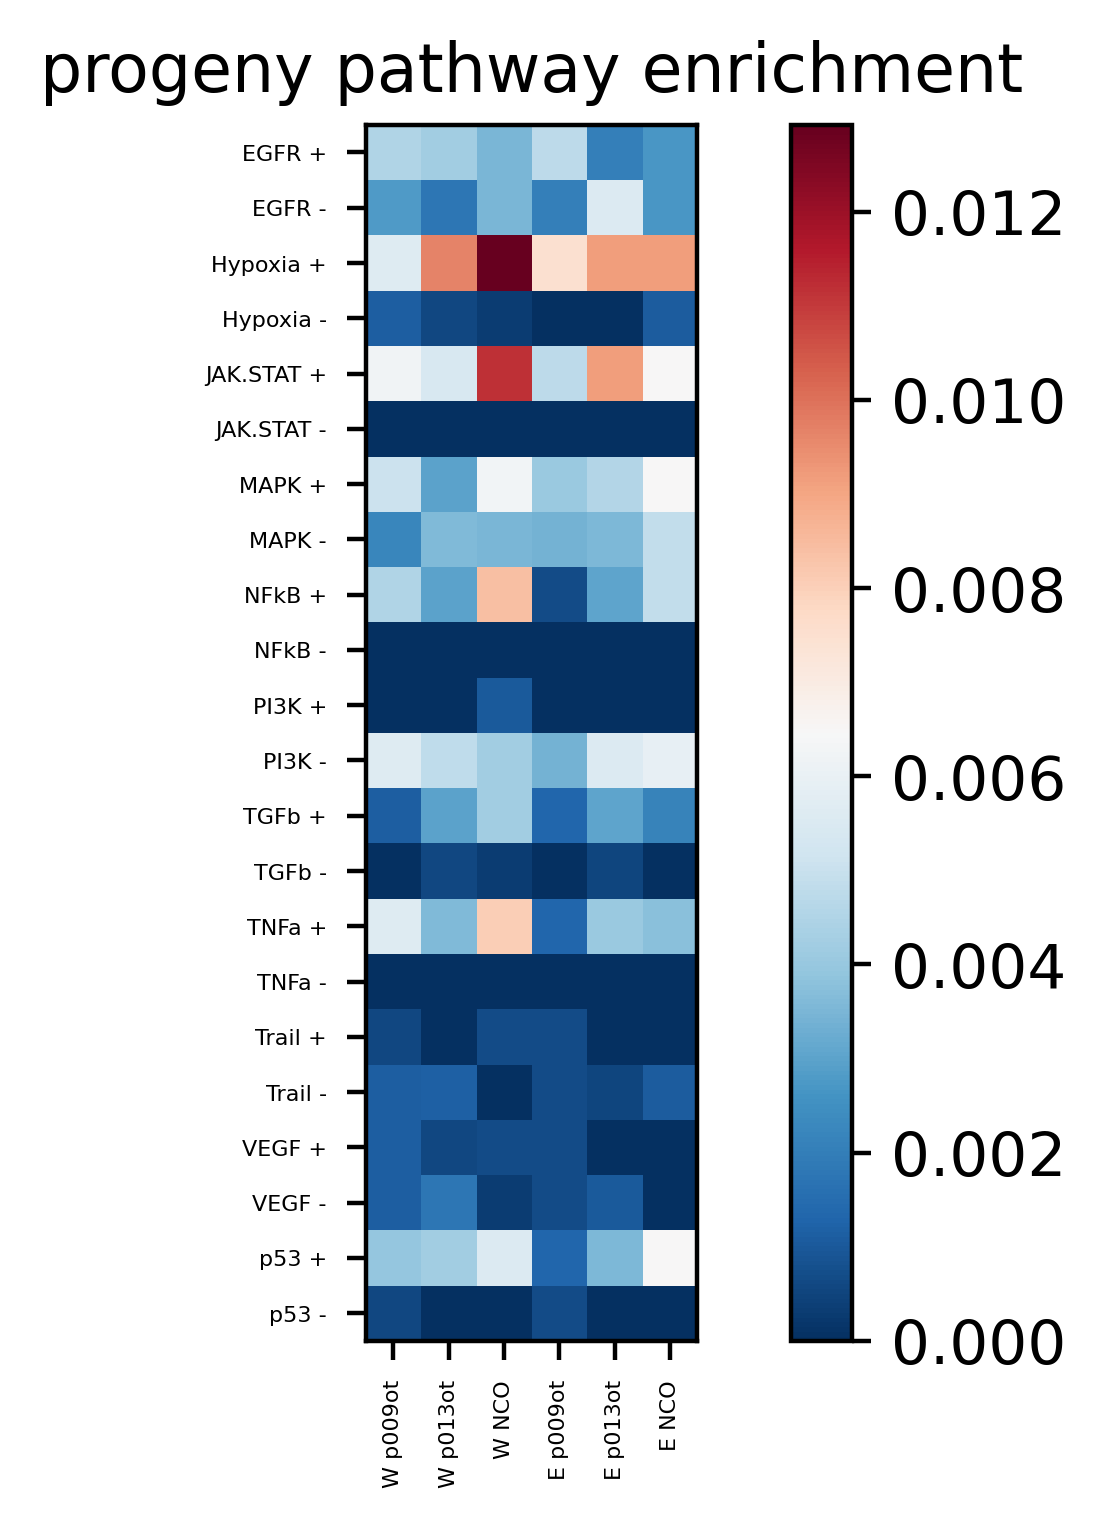

In [43]:
plot_heatmap(signature, 'progeny pathway')

# Closer look at genes

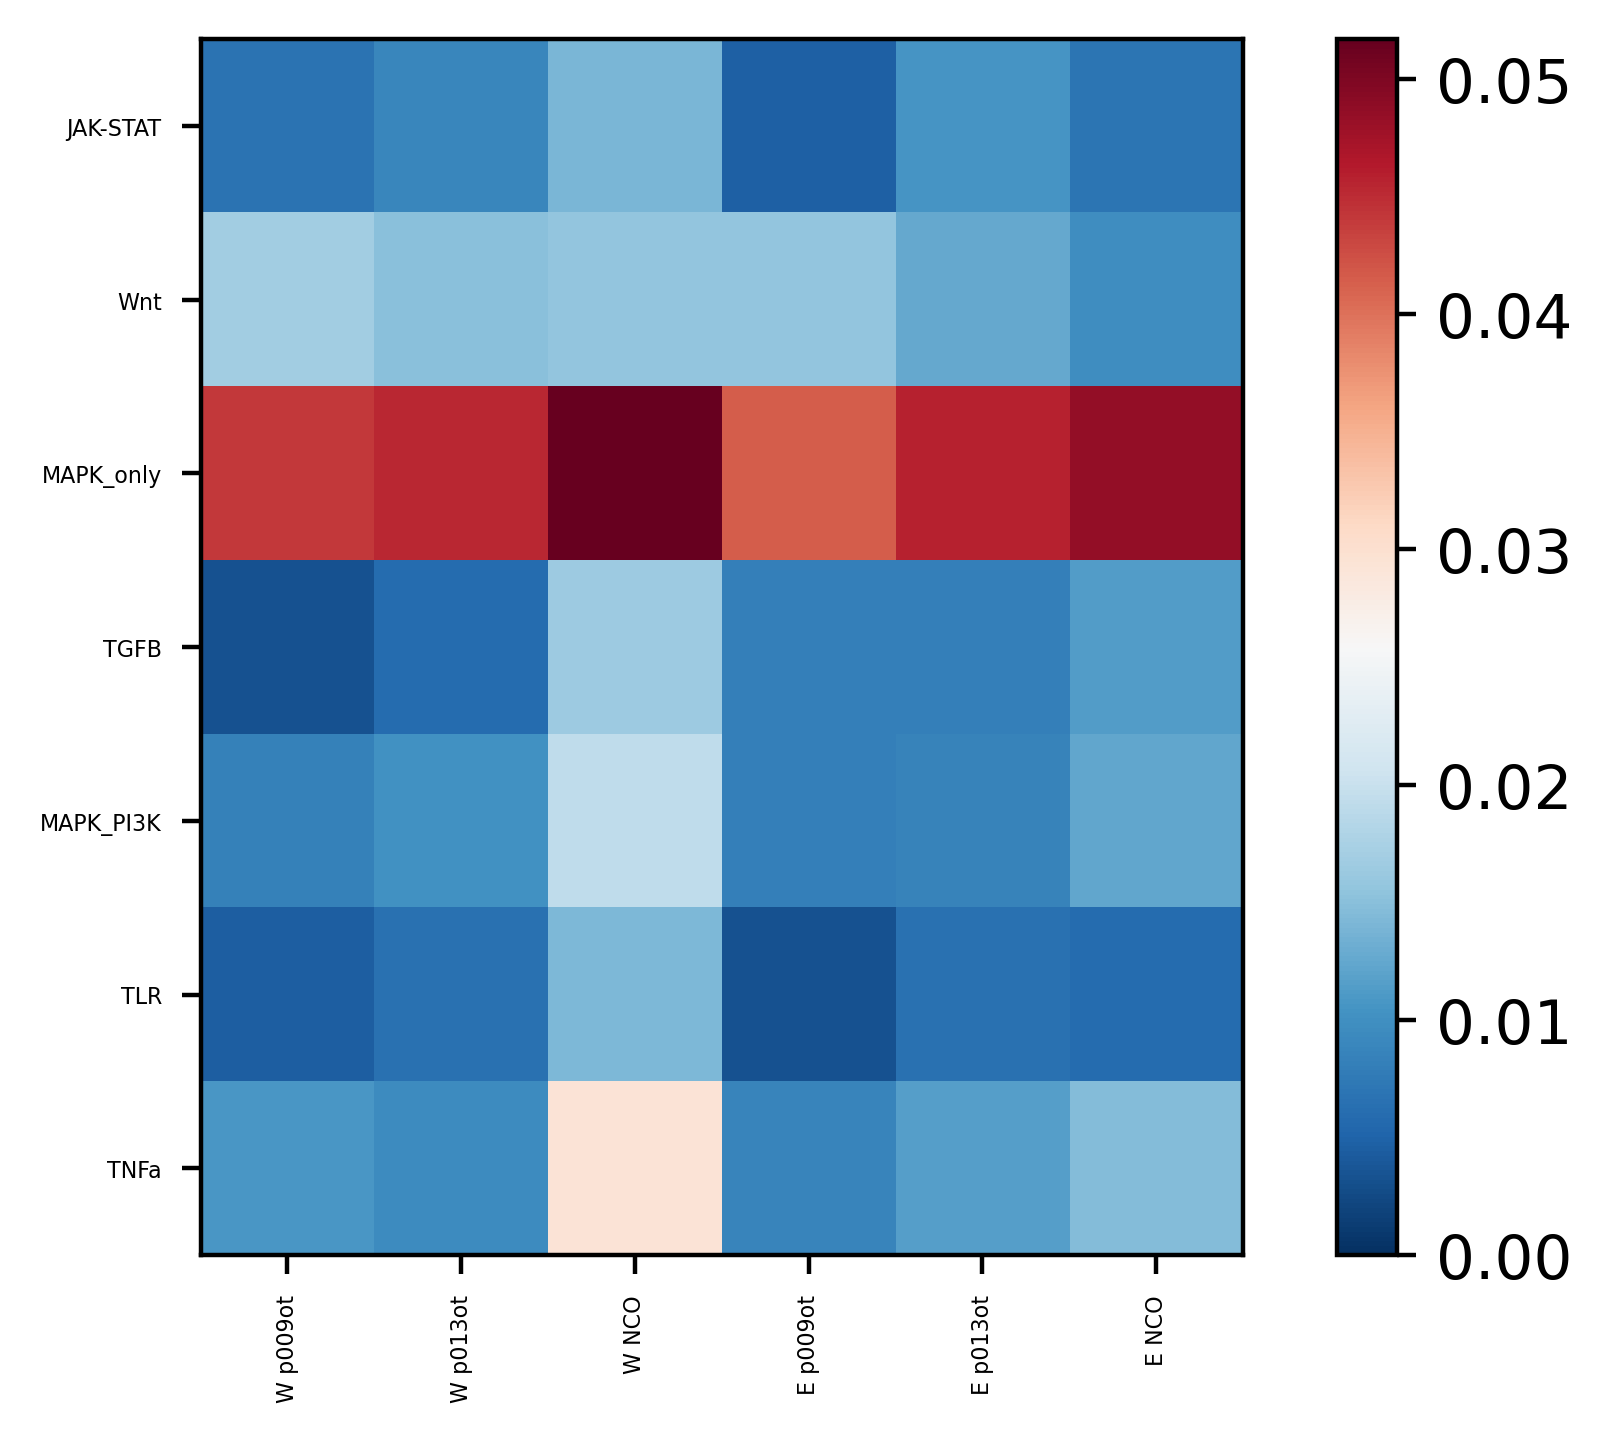

In [6]:
tab = pd.read_csv(signatures_path+'targets/progeny_pathways.csv', sep='\t', header=0)
signature = dict([(ids, tab[tab['#Pathway']==ids].Gene_Name.values) for ids in pd.unique(tab['#Pathway'])])

# progeny
a = np.zeros((len(signature.keys()), 2,3))
b = np.empty((2,3), dtype=object)
for i, letter in enumerate(['W', 'E']):
    for k, donor in enumerate(['p009ot', 'p013ot', 'NCO']):
        bdata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')

        SLAM_dyn_genes=bdata.var_names[bdata.var.dyn_velo_genes]

        # We simply count how many genes are actually used in SLAM dynamical model for each signature
        for j, ct in enumerate(signature.keys()):
            s=set(signature[ct])
            a[j,i,k]=len(SLAM_dyn_genes.intersection(s)) / len(SLAM_dyn_genes)
        b[i,k]=letter+ ' ' + donor

pl.figure(dpi=200)
im=pl.imshow(a.reshape((-1, 6)), vmin=0)
hms = signature.keys()
pl.yticks(np.arange(len(hms)), hms, fontsize=4);
pl.xticks(np.arange(6), b.reshape(6), fontsize=4, rotation=90);
pl.colorbar(im)
# pl.title(name + ' enrichment')
# pl.savefig('./figures/heatmap_'+name+'_SLAM.pdf')
pl.show()

In [39]:
ct='MAPK_only'
j = np.where(np.array(list(signature.keys()))==ct)[0][0]
s=set(signature[ct])

b = np.empty((2,3), dtype=float)
g=np.empty((2,3), dtype=object)
genes=set([])
for i, letter in enumerate(['W', 'E']):
    for k, donor in enumerate(['p009ot', 'p013ot', 'NCO']):
        bdata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        SLAM_dyn_genes=bdata.var_names[bdata.var.dyn_velo_genes]
        b[i,k]=len(SLAM_dyn_genes.intersection(s)) / len(SLAM_dyn_genes)
        g[i,k]=SLAM_dyn_genes.intersection(s)
        genes = genes.union(s)

In [43]:
pd.Series(list(genes)).to_csv('MAPK_only_relevant_dynamic_genes.csv')